Instalacja biblioteki kaggle umożliwiającej pobranie datasetu oraz Natural Language Toolkita

In [1]:
! pip install -q kaggle
! pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Ustanowienie połączenia z API Kaggle

In [2]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/ 
! chmod 600 ~/.kaggle/kaggle.json

Import wykorzystywanych bibliotek

In [3]:
import kaggle
import os
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Pobranie pliku csv zawierającego dataset treningowy klasyfikatora

In [4]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
! mkdir reviews
! unzip imdb-dataset-of-50k-movie-reviews.zip -d reviews

 93% 24.0M/25.7M [00:00<00:00, 128MB/s] 
100% 25.7M/25.7M [00:00<00:00, 115MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: reviews/IMDB Dataset.csv  


Zapisanie datasetu jako dataframe'u pandasa

In [5]:
df = pd.read_csv('reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Szczegóły analizowanego dataframe'u

In [6]:
print('Number of particular sentiments: \n{}\n'.format(df.groupby(['sentiment'])['sentiment'].count()))
print('Number of nulls: \n{}\n'.format(df.isnull().sum()))
print('Dataset info:')
df.info()

Number of particular sentiments: 
sentiment
negative    25000
positive    25000
Name: sentiment, dtype: int64

Number of nulls: 
review       0
sentiment    0
dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Analizowany dataset składa się z dwóch kolumn: kolumny review zawierającej treść recenzji oraz kolumny sentiment - zawierającej wydźwięk każdej z recenzji. Zbiór zawiera 25.000 opinii pozytywnych i tyle samo negatywnych. Każda z nich jest unikatowa. Źródłem opinii jest serwis IMDB - popularna amerykańska baza danych filmowych. Recenzje napisane są w języku angielskim.

Zamiana wydźwięku recenzji z positive/negative na maszynowe zera i jednyki

In [7]:
df['sentiment'] = df['sentiment'].replace('positive', 1)
df['sentiment'] = df['sentiment'].replace('negative', 0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Podział datasetu na część zależną i niezależną. Pozbycie się z treści recenzji słów przestankowych, specjalnych, liczb i innych. Rozszerzenie listy usuwanych słów o 'br'. Przygotowanie listy słów występujących w opiniach pozytywnych oraz listy dla opinii negatywnych. Stemming.

In [8]:
X = df['review'].copy()
y = df['sentiment'].copy()

core = []
words = []
words_positive = []
words_negative = []

ps = PorterStemmer()

nltk.download('stopwords')
new_stopwords = ["br"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

for i in range(len(X)):
  x = re.sub('[^a-zA-Z]', ' ', X[i])
  x = x.lower()
  x = x.split()
  x = [ps.stem(word) for word in x  if word not in set(stpwrd)]
  words.append(x)
  if y[i] == 1: words_positive.append(x)
  else: words_negative.append(x)
  x = " ".join(x)
  core.append(x)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
words_list = [item for sublist in words for item in sublist]
words_list_positive = [item for sublist in words_positive for item in sublist]
words_list_negative = [item for sublist in words_negative for item in sublist]

In [10]:
print(len(words_list), len(words_list_positive), len(words_list_negative))

5907650 2998739 2908911


Przygotowanie statystyki słów najczęściej występujących w recenzjach (20 najczęściej występujących) oraz dodatkowo z podziałem na wydźwięk recezji (15 najczęściej występujących z pominięciem pierwszych pięciu: movi, film, like,time, które nie mają wpływu na wydźwięk).

In [11]:
words_list = [item for sublist in words for item in sublist]
words_count = pd.value_counts(np.array(words_list))
popular_words = words_count[:20]

words_list_positive = [item for sublist in words_positive for item in sublist]
words_count_positive = pd.value_counts(np.array(words_list_positive))
popular_words_positive = words_count_positive[5:20]

words_list_negative = [item for sublist in words_negative for item in sublist]
words_count_negative = pd.value_counts(np.array(words_list_negative))
popular_words_negative = words_count_negative[5:20]

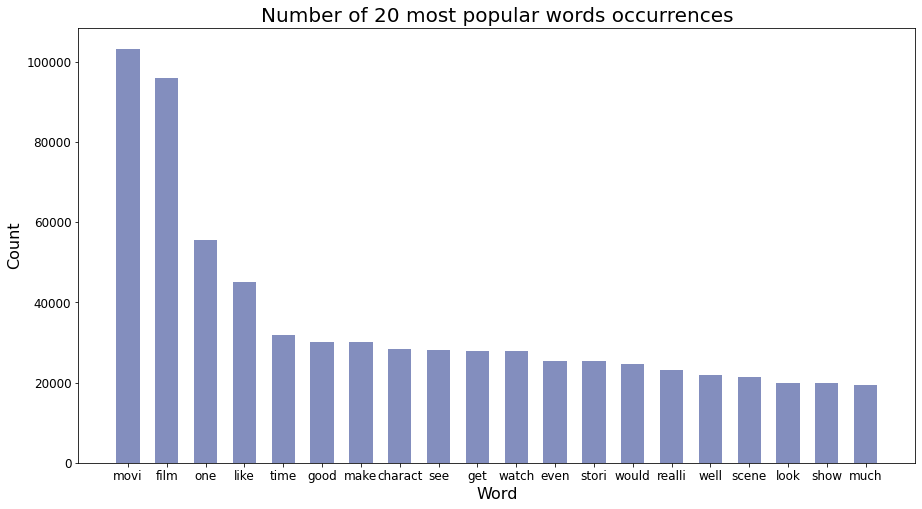

In [12]:
fig = plt.figure(figsize = (15, 8))
plt.rcParams['font.size'] = 12
plt.bar(popular_words.index, popular_words.values, color ='#838EBE', width = 0.6)
plt.xlabel('Word', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Number of 20 most popular words occurrences', fontsize=20)
plt.show()

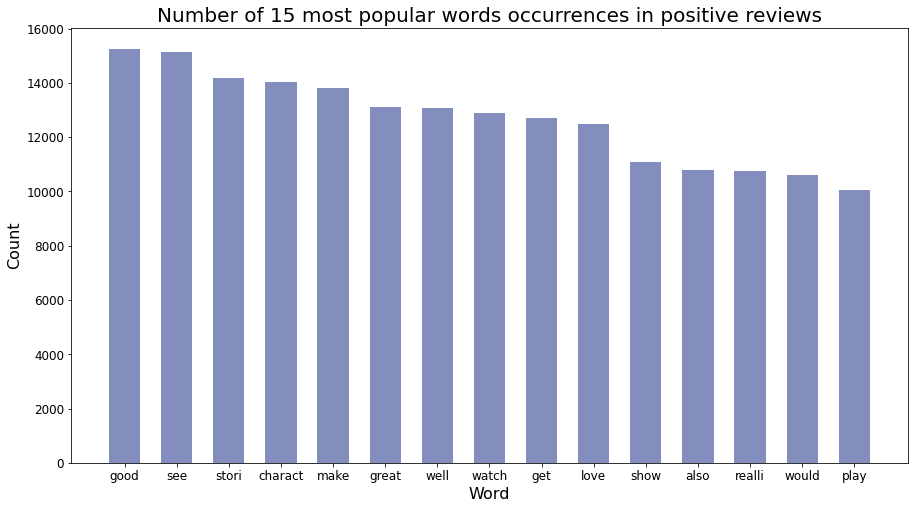

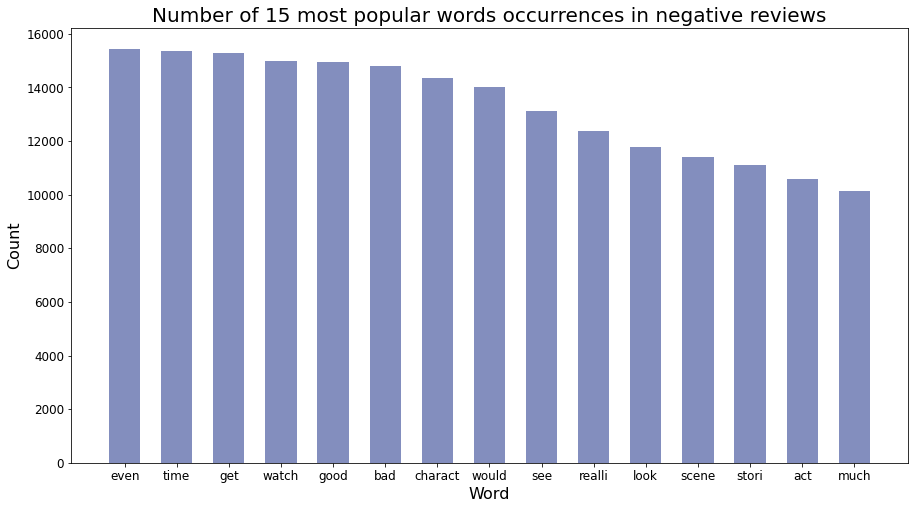

In [13]:
fig = plt.figure(figsize = (15, 8))
plt.rcParams['font.size'] = 12
plt.bar(popular_words_positive.index, popular_words_positive.values, color ='#838EBE', width = 0.6)
plt.xlabel('Word', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Number of 15 most popular words occurrences in positive reviews', fontsize=20)
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.rcParams['font.size'] = 12
plt.bar(popular_words_negative.index, popular_words_negative.values, color ='#838EBE', width = 0.6)
plt.xlabel('Word', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Number of 15 most popular words occurrences in negative reviews', fontsize=20)
plt.show()

Wśród najczęściej występujących w pozytywnych recenzjach słów znajdziemy takie jak: good, well, great, love - o nacechowaniu jednoznacznie pozytywnym. Każde z nich występuje w średnio co drugim tekście. Jednak wśród opinii negatywnych przewija się mniej słów kluczowych, mających wydźiwięk jednoznacznie negatywny. Wśród 20 najcześciej występujących znajduje się jedynie słowo bad, występujące podobnie często, jak słowo good, co może obniżać dokładność modelu. Na tej podstawie można stwierdzić, iż prostsze jest rozpoznanie opinii pozytywnych.

Wektoryzacja zmiennej tekstowej zawierającej wszystkie analizowane recenzje.

In [14]:
X = TfidfVectorizer(max_features=10000).fit_transform(core).toarray()

Podział datasetu na zbiory treningowe i testowe. W obliczeniach przyjęto, że zbiór testowy stanowi 15% całości.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=98
)

print('X_train: {}\nX_test: {}\ny_train: {}\ny_test: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train: (40000, 10000)
X_test: (10000, 10000)
y_train: (40000,)
y_test: (10000,)


Zdefiniowanie klasyfikatora bayesowskiego

In [16]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

Trenowanie modelu

In [17]:
prediction = mnb.predict(X_test)

Jakość wytrenowanego modelu

In [18]:
print(classification_report(y_test, prediction))
print(accuracy_score(y_test, prediction))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4987
           1       0.85      0.86      0.85      5013

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

0.852


Domergowanie datasetu startowego do wyników predykcji w celu analizy źle ocenionych przez model recenzji 

In [19]:
rev = list(y_test.index)
pred = list(prediction)

df_compare = pd.DataFrame()
df_compare['rev'] = rev
df_compare['pred'] = pred

df_compare = df_compare.merge(df,left_on='rev', right_index=True, how='left')

In [20]:
diffs = df_compare.query('pred != sentiment')

for i in range(5):
  print(diffs.iloc[i]['review'])

so halfway through the season, i got so caught up in school and my activities that i didn't realize that the show had been canceled halfway through, which is crap.<br /><br />i think the followers of this show should write fox and ask them to at least finish filming so that a the season can be released on DVD later. maybe then they'll see how many people were disappointed that the show didn't survive its first season.<br /><br />i loved the show and looked forward to it every thursday after the OC. can you imagine my disappointment when i came back to try and watch the show only to discover that it had disappeared? needless to say, i'm not very happy with fox right now. even more so after discovering that NO ENDING WAS FILMED. i mean, if you're going to work on a project, at least finish it to see what happens. a half filmed show is like a half made car, it's pretty much useless. fox, film the damn ending and give some of the show's fans some peace.
There are just so many things wrong 

Analiza źle zinterpretowanych przez model recenzji może być przedmiotem dalszych analiz mających na celu poprawę wydajności modelu.